# Калибровка моделей

Во многих задачах нам нужно знать не только метку класса которая была предсказана, но и уверенность модели в этом классе. Это может быть важно со многих точек зрения:

- для интерпретируемость модели, хочется понимать насколько можно доверять тому или иному решению. Особенно это актуально для задачи скоринга.
- В некоторых задачах где есть разная цена ошибки нужно считать матожидание некоторой величины, а это в свою очередь вероятность * цена ошибки. В этом случае мы хотим использовать настоящие вероятности. Пример: мы показываем баннеры, клик по разным баннерам дает разный reward, следовательно мы хотим показать те баннеры где вероятность * reward максимальная, следовательно если вероятности не настоящие, мы выбрать баннеры не сможем.
- в системах human in the loop, нужно понимать стоит ли переводить задачу на человека или можно довериться модели
- часто уверенность модели используется в ML пайплайне другими моделями. Тогда калибровка помогает второй модели сходиться, калибровка работает как нормальлизация данных. Например  для stacking. Яркий пример это языковые модели, где для генерации используются вероятности токенов)
- может использоваться для semi-supervised learning, например pseudo-labeling чтобы понимать в каких ответах мы действительно уверены и готовы взять в обучение. Аналогично в active learning
- калибровка помогает улучшить стабильность/робасность модели. Допустим модель хорошая но не стабильная, то есть при пороге например 0.95 дает отличное качество, а вот для 0.94 будет давать отвратительное качество. Тогда при малейшем изменении данных модель пойдет к чертям. Калибровка помогает с этим, она дает гарантии по этой отсечке.
- во многих практических задачах есть вариант не делать предсказание и “сказать не знаю” и это бывает практичней чем сделать предсказание и с большой вероятностью ошибиться.

In [40]:
import os
from typing import List, Tuple, Dict, Union, Callable, Optional

import netcal  # библиотека для калибровки моделей
import pandas as pd
import torch
import timm 
import numpy as np
import scipy
import matplotlib.pyplot as plt
import albumentations as albu
import cv2

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from catalyst import dl, utils
from catalyst.contrib.datasets import Imagewoof
from catalyst.engines import DeviceEngine
from catalyst.contrib.nn.criterion import FocalLossMultiClass
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from albumentations.pytorch import ToTensorV2 as ToTensor
from netcal.binning import HistogramBinning, IsotonicRegression
from netcal.scaling import TemperatureScaling
from netcal.metrics import ECE, MCE
from netcal.presentation import ReliabilityDiagram

RANDOM_STATE = 42
IMAGE_SIZE = 224
BATCH_SIZE = 128
NUM_WORKERS = 12
N_CLASSES = 10
N_BINS = 10
DEVICE = "cuda:1"

In [41]:
def subplot_images(
    images: List[np.ndarray],
    n_rows: int,
    n_columns: int,
    figsize: Tuple[int, int] = (20, 20),
    titles: Optional[Union[str, List[Optional[str]]]] = None,
    cmap: Optional[str] = None,
    axis: bool = False,
    layout_pad: Tuple[float, float] = (1, 1),
) -> None:
    assert len(images) <= n_rows * n_columns
    if titles is None or isinstance(titles, str):
        titles = [titles] * len(images)
    plt.figure(figsize=figsize)
    for i, image in enumerate(images, start=1):
        plt.subplot(n_rows, n_columns, i, ymargin=0.5, xmargin=0.5)
        plt.title(titles[i - 1])
        if not axis:
            plt.axis("off")
        plt.tight_layout(w_pad=layout_pad[0], h_pad=layout_pad[1])
        plt.imshow(image, cmap)
    plt.show()

Для примера будем использовать подвыборку ImageNet под названием Imagewoof. Этот датасет содержит изображения собак разных пород выделенных в 10 классов

In [2]:
# класс обработчик для датасета
class ImageNetDataset(Dataset):
    def __init__(self,
                 data: List[Dict[str, Union[str, int]]],
                 transform: albu.Compose,
                 target_transform: Optional[Callable[[int], torch.Tensor]] = None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        image = cv2.imread(self.data[idx]['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        transformed_image = self.transform(image=image)['image']
        target = self.data[idx]['targets']
        if self.target_transform is not None:
            target = self.target_transform(target)
        return {'image': transformed_image, 'targets': target}
    
    def __len__(self) -> int:
        return len(self.data)

In [3]:
# скачиваем данные
train_data = Imagewoof(os.getcwd(), train=True, download=True).data
test_data = Imagewoof(os.getcwd(), train=False, download=True).data

# простой препроцессинг изобаржений 
transform = albu.Compose([
    albu.LongestMaxSize(IMAGE_SIZE, cv2.INTER_LANCZOS4),
    albu.PadIfNeeded(IMAGE_SIZE, IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT),
    albu.Normalize(),
    ToTensor()])
    

# так как в датасете нет валидации, выделим часть трейна под валидацию(стратифицируя по классам)
train_data, valid_data = train_test_split(train_data,
                                          test_size=0.2,
                                          random_state=RANDOM_STATE,
                                          stratify=[i['targets']for i in train_data])

# создаем датасеты
train_dataset = ImageNetDataset(train_data, transform=transform)
valid_dataset = ImageNetDataset(valid_data, transform=transform)
test_dataset = ImageNetDataset(test_data, transform=transform)

print('train_dataset size: ', len(train_dataset))
print('valid_dataset size: ', len(valid_dataset))
print('test_dataset size: ', len(test_dataset))

# создаем лоадеры
loaders = {
    "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "valid": DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "test": DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
}

train_dataset size:  7220
valid_dataset size:  1805
test_dataset size:  3929


Примеры изображения для каждого класса

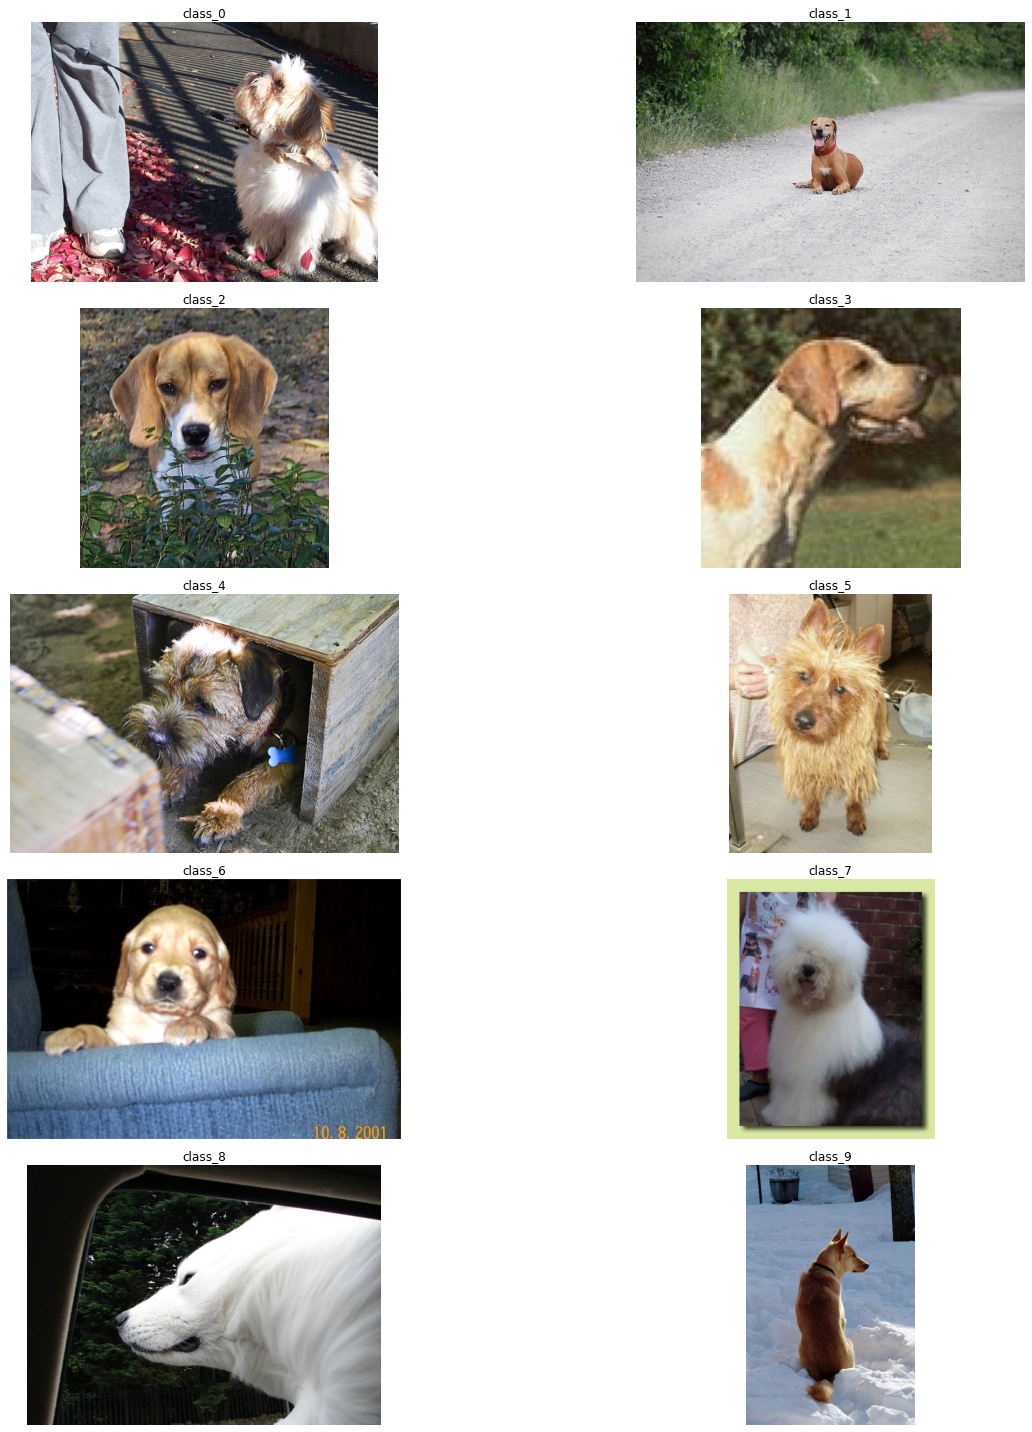

In [4]:
image_per_class: List[np.ndarray] = []
for class_idx in range(N_CLASSES):
    for sample in train_data:
        if sample['targets'] == class_idx:
            image = cv2.imread(sample['image'])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_per_class.append(image)
            break
subplot_images(image_per_class, 5, 2, titles=[f'class_{class_idx}' for class_idx in range(N_CLASSES)])

Обучаем модель классификации, код обучения написан на catalyst, слабонерным не смотреть!


__Замечание__: В этом примере нет намерения получить высокое качество. Цель продемонстировать методы калибровки. Поэтому используется довольно простой пайплайн!

In [1]:
# берем простую модель mobilenet_v2
model = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=10)

# в качестве лосс функцию обычную кросэнтропию
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.02)
runner = dl.SupervisedRunner(
    input_key="image", output_key="logits", target_key="targets", loss_key="loss"
)

# обучение модели
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders={'train': loaders['train'], 'valid':loaders['valid']},
    engine=DeviceEngine(DEVICE),
    num_epochs=30,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5)),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
    ],
    logdir="./logs_1",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
)

In [5]:
# берем простую модель mobilenet_v2
model = timm.create_model('mobilenetv2_100', pretrained=False, num_classes=10)
# # просто замечание: часто можно бесплатно увеличить качество моделей, если усреднять веса с разных чекпоинтов(и улучшает калибровку)
# model.load_state_dict(utils.get_averaged_weights_by_path_mask(logdir="./logs_1", path_mask="*.pth"))

model.load_state_dict(torch.load('./logs_1/checkpoints/best_full.pth')['model_state_dict'])

<All keys matched successfully>

In [6]:
def predict_loader(loader: DataLoader,
                   model: torch.nn.Module,
                   activation: Optional[Callable[[np.ndarray], np.ndarray]] = None,
                   device: str = 'cuda') -> Tuple[np.ndarray, np.ndarray]:
    """
    Делает предсказания для loader
    
    :param loader: DataLoader: loader данных
    :param model: torch.nn.Module: модель
    :param activation: Optional[Callable[[np.ndarray], np.ndarray]]: функция активации
    :param device: str: название девайса на котором нужно делать вычисления
    :return: Tuple[np.ndarray]: вероятности для каждого объекта, размерность (n_objects, n_classes) и истинные метки для
    каждого объекта, размерность (n_objects, )
    """
    model.eval()
    model.to(device)
    probs_per_image: List[np.ndarray] = []
    targets = []
    for batch in loader:
        logits = model(batch['image'].to(device)).detach().cpu().numpy()
        for logit, target in zip(logits, batch['targets']):
            probs = activation(logit) if activation is not None else logit
            probs_per_image.append(probs)
            targets.append(target)
    return np.array(probs_per_image), np.array(targets)

делаем предсказания для валидации и теста

In [7]:
valid_logits, valid_targets = predict_loader(
    loader=loaders['valid'],
    model=model)
valid_probs = scipy.special.softmax(valid_logits, axis=1)

test_logits, test_targets = predict_loader(
    loader=loaders['test'],
    model=model)
test_probs = scipy.special.softmax(test_logits, axis=1)

Посмотрим насколько вероятности которая предсказываем модель соответствуют реальноному accuracy. 

Для этого разобьем вероятности на бины и для каждого бина определим какое в нем acuracy

In [8]:
predicted_score = np.max(test_probs, axis=1)  # берем карсимальную уверенность по каждому объекту
predicted_class = np.argmax(test_probs, axis=1)  # берем наиболее вероятный класс
is_correct = predicted_class == test_targets  # верно ли предсказали

In [9]:
bin_edges = np.linspace(0, 1, N_BINS + 1)  # определяем границы бинов
bin_indices = np.digitize(predicted_score, bin_edges)  # для каждого объекта определяем к каком бину он принадлежит

bins_accuracy = np.array([])
bins_confidence = np.array([])
bins_size = np.array([])
for bin_idx in range(N_BINS + 1):
    bin_size = len(np.where(bin_indices == bin_idx)[0])
    if bin_size:  # может оказаться что в определенный бин ничего не попало
        bins_size = np.append(bins_size, bin_size)
        bins_accuracy = np.append(bins_accuracy, is_correct[np.where(bin_indices == bin_idx)].mean())
        bins_confidence = np.append(bins_confidence, predicted_score[np.where(bin_indices == bin_idx)].mean())

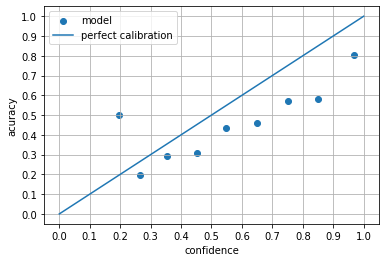

In [10]:
plt.scatter(bins_confidence, bins_accuracy, label='model')
plt.xlabel('confidence')
plt.ylabel('acuracy')
plt.xticks(ticks=np.linspace(0, 1, N_BINS + 1))
plt.yticks(ticks=np.linspace(0, 1, N_BINS + 1))
plt.plot(np.linspace(0, 1, N_BINS + 1), np.linspace(0, 1, N_BINS + 1), label='perfect calibration')
plt.legend()
plt.grid()
plt.show()

__Видно что модель слишком уверенна в своих ответах!__

### Определение
Определим более формальное определение калибровки. Путь мы решаем задачу классификации на l классов, алгоритм выдает некоторые оценки вероятности принадлежности к классу, то есть: 

$b(x) = (b_1(x), ... , b_l(x)) \in[0, 1]^l)$ 

и выбирается ответ с наибольшей уверенность: 

$a(x) = \underset{j}{argmax}(b_j(x))$ .

Хотелось бы чтобы эта вероятность равна была вероятности которую выдает алгоритм, то есть

 $b_{a(x)}(x) \approx P(y(x) = a(x))$. 

Если это равенство  выполняется, то можно сказать что модель откалибрована. Может быть и более жесткое условие чтобы все оценки вероятностей, а не только наиболее вероятная, соответствовали реальной вероятности, то есть:

$b_{k}(x) \approx P(y(x) = k)$

### Метрики

**Expected Calibration Error (ECE)**

Одна из метрик ралибровки выглядит следующим образом

$ECE = \mathbb{E}[|b_k(x) - P(y(x) = k)|]$

Точнее, ECE обычно оценивают, усредняя по бинам, или чаще взвешивая по «частоте бина»: сначала выделяются бины, как правило (0, 0.1), …, (0.9, 1) и в каждом вычисляется доля объектов которые попали в эти бины:  $b_{bin_i}$ - доля объектов которые попали в этот bin по вероятности и 

$ECE = \frac{1}{|\{B\}|} \underset{B \in \{B\}}{\sum} \frac{|B|}{m} |\frac{1}{|B|} \underset{{x \in B}}{\sum} b_k(x) - \frac{1}{|B|} \sum_{x \in B} I[y(x) = k]|$

Для каждого бина считаем среднее значение вероятности в нем и отнимаем долю объектов которые действительно принадлежат данному классу и суммируем по всем классам.

Чащё бины выбирают «равной ширины», но более предпочтительный вариант – равной мощности, тогда метрику качества называют **daECE (Adaptive ECE)**.


**Maximum Calibration Error (MCE)**
Вместо среднего иногда используют максимум:

$MCE = \underset{B}{max} |\underset{{x \in B}}{\sum} b_k(x) -  \sum_{x \in B} I[y(x) = k]|$

Также калибровку оценивают стандартными функциями ошибки: **negative log-likelihood (NLL)**
 и **Brier score** (так в классификации часто называют MSE):

$NLL = -\frac{1}{m} \sum_{j=1}^m{y_jlog({b_j})}$  $BS = \frac{1}{m} \sum_{j=1}^m(y_j -b_j)^2$

Посчитаем для нашей модели эти метрики

In [11]:
ece = np.sum(np.abs(bins_confidence - bins_accuracy) * bins_size / np.sum(bins_size))
mce = np.max(np.abs(bins_confidence - bins_accuracy))

print("ECE: ", np.round(ece, 3))
print("MCE: ", np.round(mce, 3))

ECE:  0.167
MCE:  0.305


**Замечание**: Все всех метриках/методах связанных с бинами есть 2 стратегии как создавать бины: равномерно(деля отрезок [0, 1] на определенное количество равных частей) и делить на бины так, чтобы в каждом бине было одинаковое количество объектов.

При использовании “равномерных” бинов могут быть ряд проблем:

- в отдельный бин может попасть очень мало объектом и тогда оценка для этого бина будет не статистически значима
- может оказаться что некоторые бины пустые(например,если мы классифицируем очень редкое событие(клик по баннеру)), и получиться что оценка станет достаточно грубой

In [12]:

def show_calibration(probs: np.ndarray,
                     targets: np.ndarray,
                     n_bins: int = 10,
                     equal_intervals: bool = True,
                     label: Optional[str] = None) -> Tuple[float, float, float]:
    ece = ECE(n_bins, equal_intervals=equal_intervals).measure(probs, targets)
    mce = MCE(n_bins, equal_intervals=equal_intervals).measure(probs, targets)
    accuracy = top_k_accuracy_score(targets, probs, k=1)
    print("ECE: ", np.round(ece, 3))
    print("MCE: ", np.round(mce, 3))
    print("accuracy", np.round(accuracy, 3))
    
    reliability_diagram = ReliabilityDiagram(n_bins, equal_intervals=equal_intervals)
    _ = reliability_diagram.plot(probs, targets)
    
    pred_probs = np.max(probs, axis=1)
    is_correct = np.argmax(probs, axis=1) == targets
    
    prob_true, prob_pred = calibration_curve(is_correct, pred_probs, n_bins=n_bins)
    disp = CalibrationDisplay(prob_true, prob_pred, pred_probs)
    disp.plot(name=label)
    plt.grid()
    plt.title("Calibration curve")
    plt.show()
    
    return ece, mce, accuracy



def show_calibration_per_class(probs: np.ndarray,
                               targets: np.ndarray,
                               n_bins: int = 10,
                               label: Optional[str] = None,
                               figsize: Tuple[int, int] = (20, 14),
                               transformed_probs: Optional[np.ndarray] = None,
                               transformed_label: Optional[str] = None) -> None:
    n_classes = len(probs[0])
    fig = plt.figure(figsize=figsize)
    for class_idx in range(n_classes):
        # считаем ECE для каждого класса по отдельности
        class_probs = probs[:, class_idx]
        is_correct = targets == class_idx
        ece = ECE(n_bins, equal_intervals=True).measure(class_probs, is_correct)
        
        prob_true, prob_pred = calibration_curve(is_correct, class_probs, n_bins=n_bins)
        disp = CalibrationDisplay(prob_true, prob_pred, class_probs)
        
        ax = plt.subplot(5, 2, class_idx+1,)
        ax.grid()
        ax.set_title(f'class_{class_idx}: ECE = {np.round(ece, 3)}')
        plt.tight_layout(w_pad=2, h_pad=1)  # чтобы графики не пересекались
        disp.plot(ax=ax, name=label)
        # если есть трансформированные вероятности, то отображаем их
        if transformed_probs is not None:
            transformed_class_probs = transformed_probs[:, class_idx]
            transformed_prob_true, transformed_prob_pred = calibration_curve(is_correct,
                                                                             transformed_class_probs, n_bins=n_bins)
            transformed_disp = CalibrationDisplay(transformed_prob_true,
                                                  transformed_prob_pred,
                                                  transformed_class_probs)
            transformed_disp.plot(ax=ax, name=transformed_label)
    plt.show()

ECE:  0.167
MCE:  0.305
accuracy 0.583


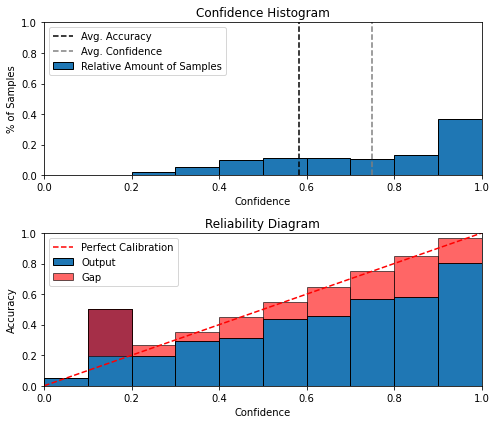

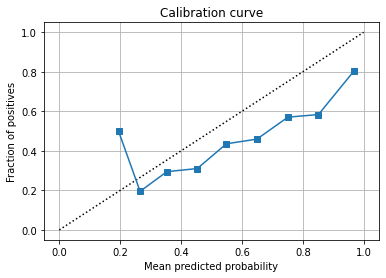

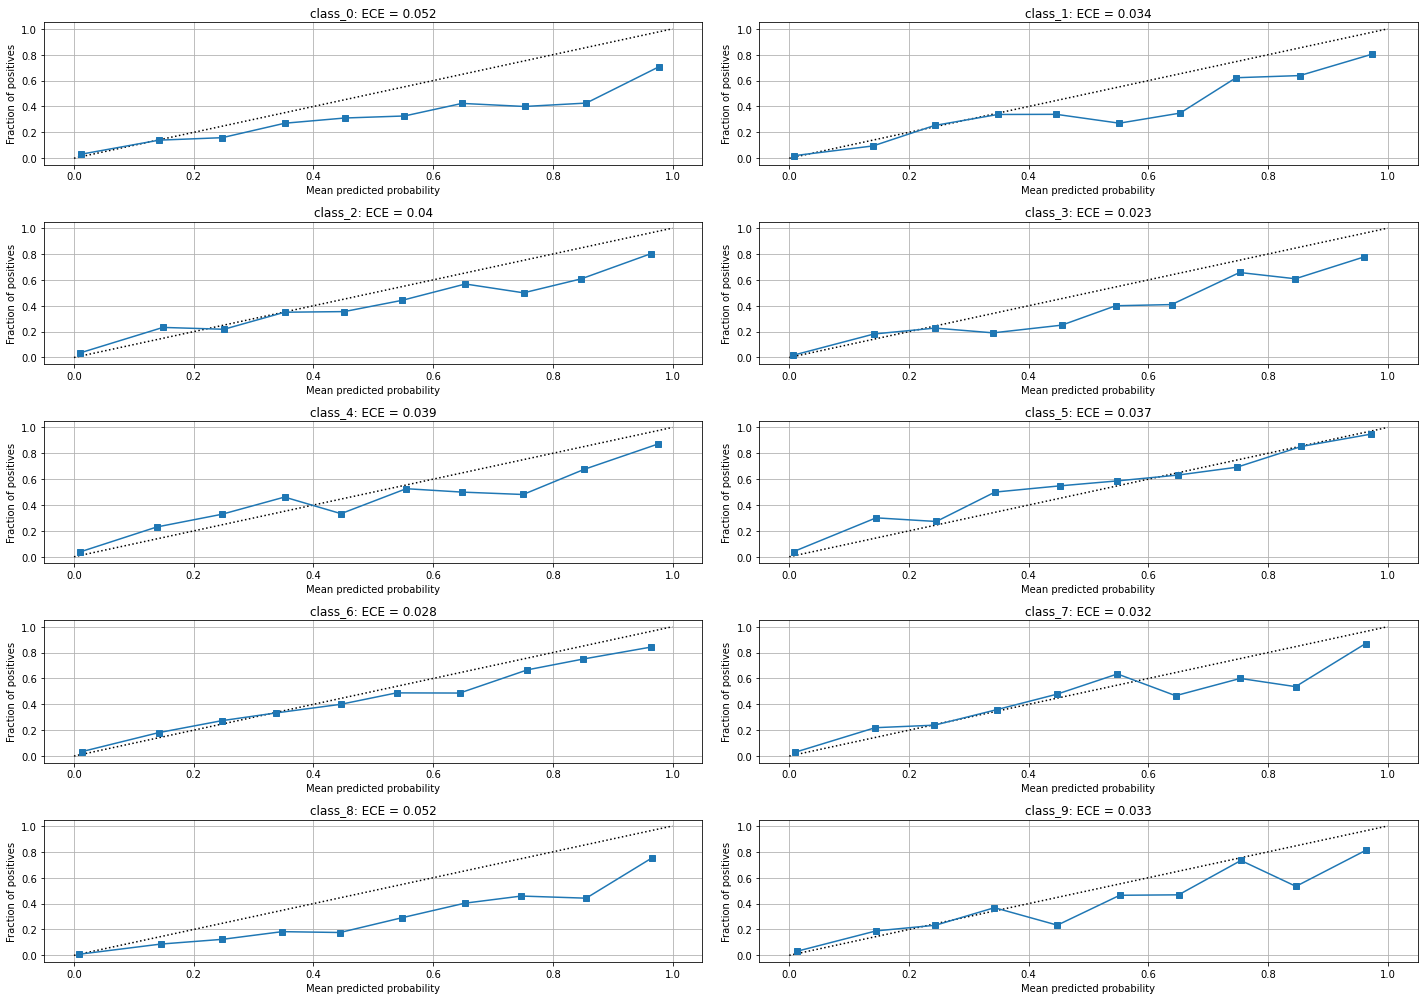

In [13]:
metrics = show_calibration(test_probs, test_targets, n_bins=N_BINS)
# можно смотреть на калибровку по каждому классу отдельно!
show_calibration_per_class(test_probs, test_targets, n_bins=N_BINS)

### Histogram Binning


Идея в том что для каждого бина подбирать оптимальное значение вероятности и потом заменять значение модели на значение в соответствующем бине, то есть решается следующая задача:

$\sum_{i=1}^{k} \sum_{b(x) \in \{B_i\}}(\theta_i - y(x))^2 \rightarrow min$

Изначально в методе использовались бины одинаковой ширины (но можно использовать и равномощные). После решения задачи, если оценка принадлежности к классу попала в $i$-й бин, её заменяют на соответствующее значение $\theta_i$.

**Замечание**: $\theta_i$ можно подбирать общие для всех классов, а можно(если используется сигмоида) подбирать для каждого класса по отдельности. Однако тогда количество подбираемых параметров сильно увеличиться 

 Минусы такого подхода:

- число бинов задаётся изначально,
- нет непрерывности у функции деформации,
- в «равноширном варианте» в некоторых бинах содержится малое число точек.
- не гарантирует монотонности, то есть модет так случиться что следующий бин будет иметь меньшее значение чем предыдущий, то есть может быть такое: 0.65 перейдет в 0.5,  а 0.75 в 0.45

__Замечание__: Насчет библиотеки `netcal`,
- практически все методы работают в стратегии one vs all что не всегда может быть желанно. Поэтому чтобы сделать калибровку только по основной(максимальной) вероятности, нужно сделать бинарную калибровку и потом применять ее ко всем классам

- алгоритмы binning не поддерживают(на момент 29.03.2023) вариант равномощных бинов. Это может привести(с учетом предыдущего пункта) к тому что при сильном дисбалансе классов он может работать не слишком хорошо!

ECE:  0.036
MCE:  0.078
accuracy 0.582


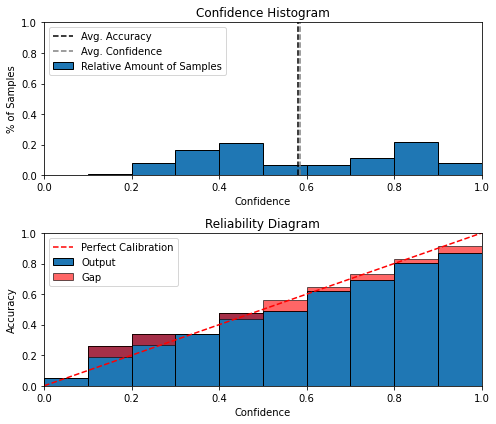

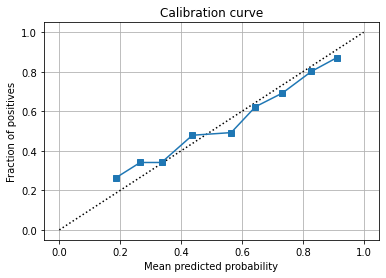

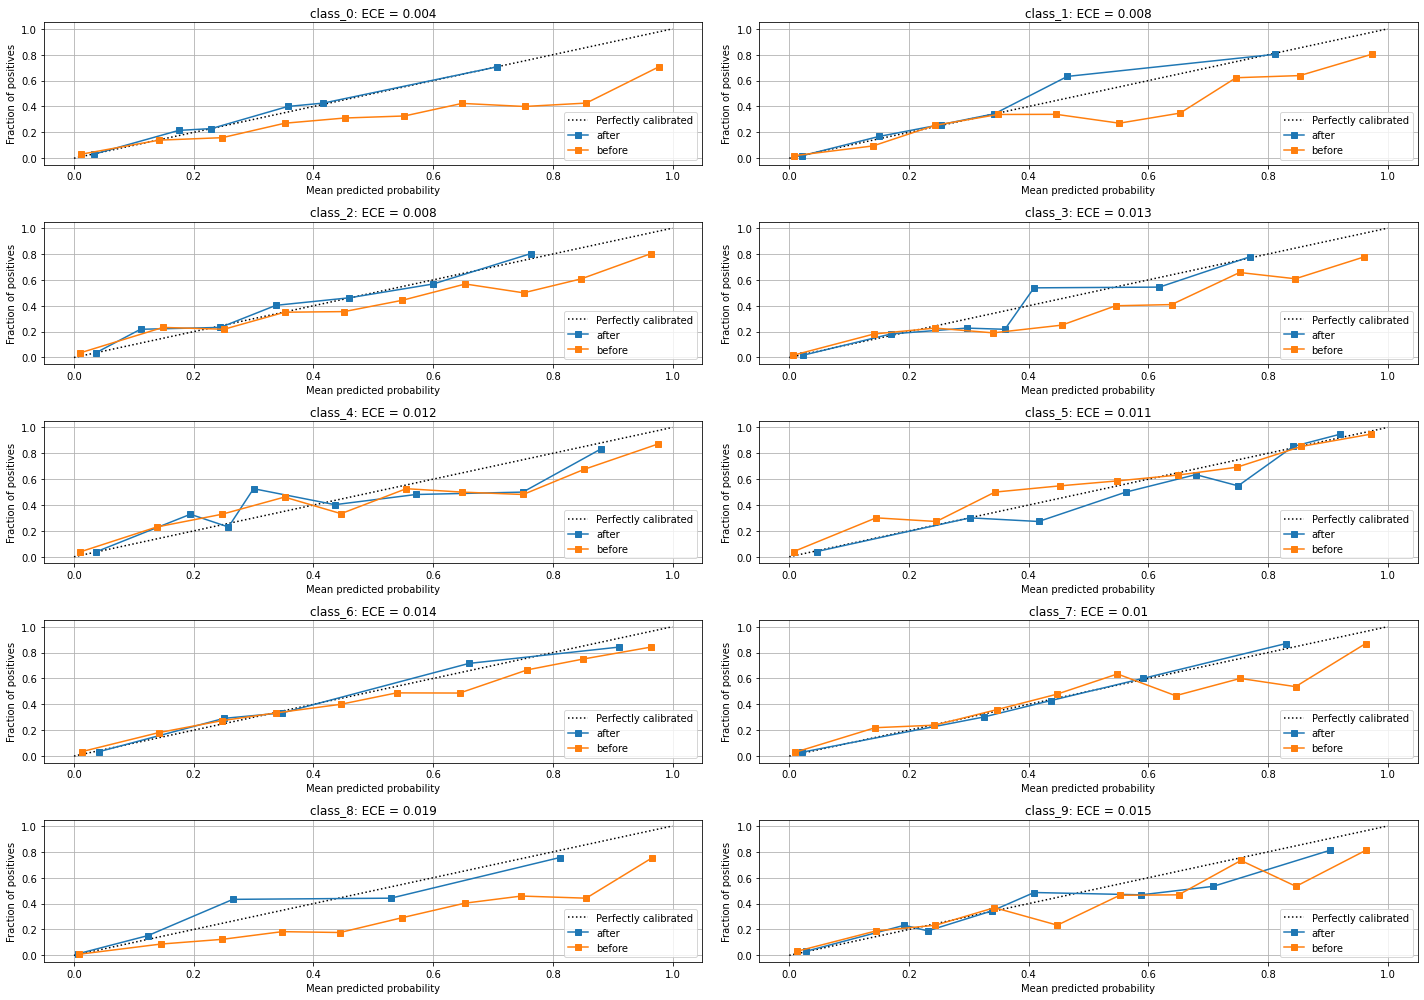

In [18]:
# independent_probabilities определяет нужно ли нормализовывать вероятности!
histogram_binning = HistogramBinning(N_BINS, independent_probabilities=True)
histogram_binning = histogram_binning.fit(valid_probs, valid_targets)
binning_test_probs = histogram_binning.transform(test_probs)

binning_metrics = show_calibration(binning_test_probs, test_targets, n_bins=N_BINS)
# можно смотреть на калибровку по каждому классу отдельно!
show_calibration_per_class(binning_test_probs, test_targets, n_bins=N_BINS, label='after',
                           transformed_probs=test_probs, transformed_label='before')

Это binning в стратегии `one vs all` , можно сделать binning по основной вероятности и применить ко всем классам

In [15]:
predicted_score = np.max(valid_probs, axis=1)  # берем карсимальную уверенность по каждому объекту
predicted_class = np.argmax(valid_probs, axis=1)  # берем наиболее вероятный класс
is_correct = predicted_class == valid_targets  # верно ли предсказали

# раз у нас меньше будет "настраиваемых" параметров, можно увеличить количество бинов
histogram_binning_v2 = HistogramBinning(N_BINS * 2, independent_probabilities=True)
histogram_binning_v2 = histogram_binning_v2.fit(predicted_score, is_correct)

binning_test_probs_v2 = test_probs.copy()
for idx in range(test_probs.shape[1]):
    binning_test_probs_v2[:, idx] = histogram_binning_v2.transform(binning_test_probs_v2[:, idx])

ECE:  0.035
MCE:  0.093
accuracy 0.58


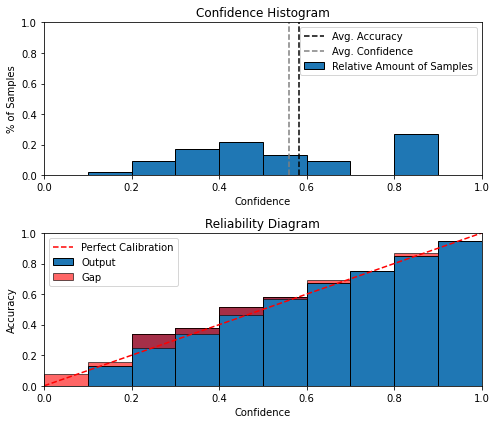

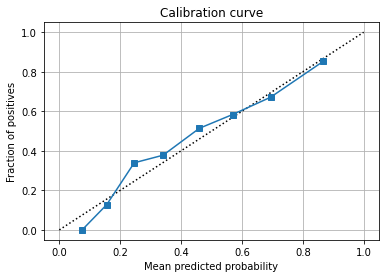

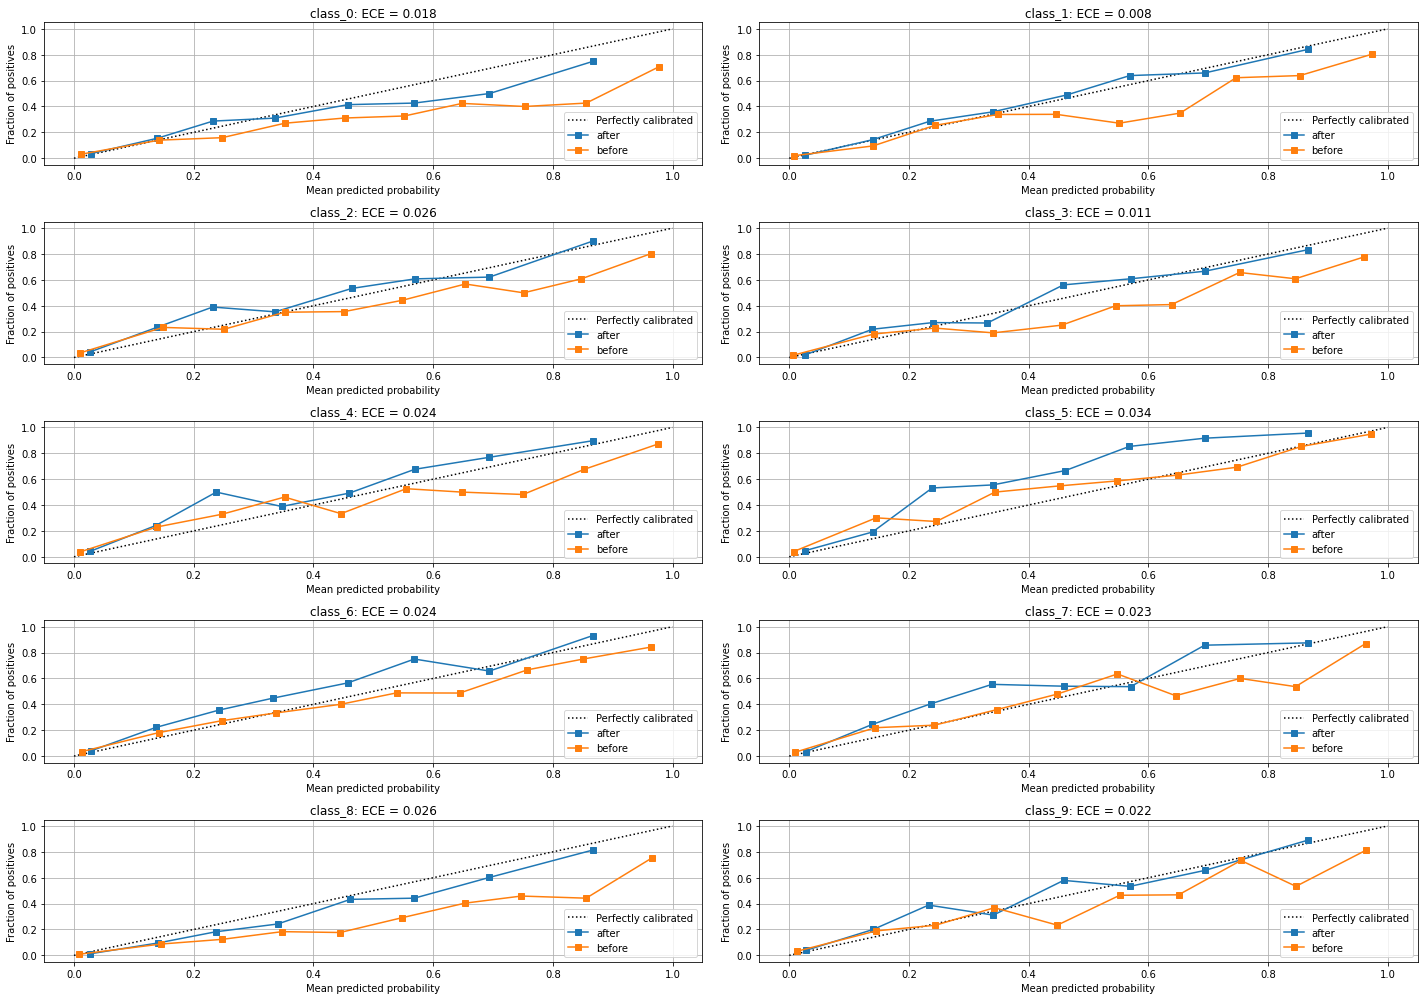

In [16]:
binning_metrics_v2 = show_calibration(binning_test_probs_v2, test_targets, n_bins=N_BINS)
# можно смотреть на калибровку по каждому классу отдельно!
show_calibration_per_class(binning_test_probs_v2, test_targets, n_bins=N_BINS, label='after',
                           transformed_probs=test_probs, transformed_label='before')

### BBQ (Bayesian Binning into Quantiles)

Ансамбль алгоритмов калибровки, который осуществляет комбинация нескольких биннингов (равномощных) с разным числом бинов. Ответ ищется в виде линейной комбинации оценок бинингов с весами, применяется байесовское усреднение. Подробнее [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4410090/)

**Замечание**: реализован в `netcal.binning.BBQ()`

### IsotonicRegression

Строится монотонно неубывающая функция деформации оценок алгоритма. По сути, решается такая же задача оптимизации, как и в предыдущем методе, но есть дополнительное условие:

$\theta_1 < \theta_2 < ... \theta_k$

По-прежнему, функция деформации не является непрерывной, а оптимизацию проводят по параметрам $k, {θ_i}, {α_i}$. Подробнее [link](https://scikit-learn.org/stable/modules/isotonic.html#isotonic)

In [21]:
isotonic_regression = IsotonicRegression(independent_probabilities=True)
isotonic_regression.fit(valid_probs, valid_targets)
isotonic_test_probs = isotonic_regression.transform(test_probs)
isotonic_valid_probs = isotonic_regression.transform(valid_probs)

ECE:  0.053
MCE:  0.21
accuracy 0.592


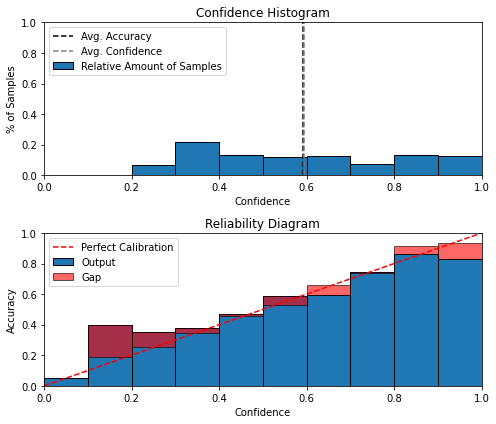

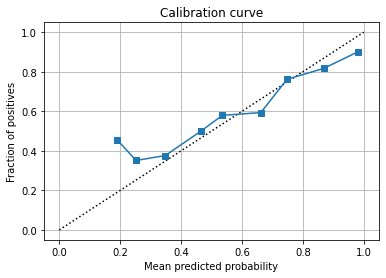

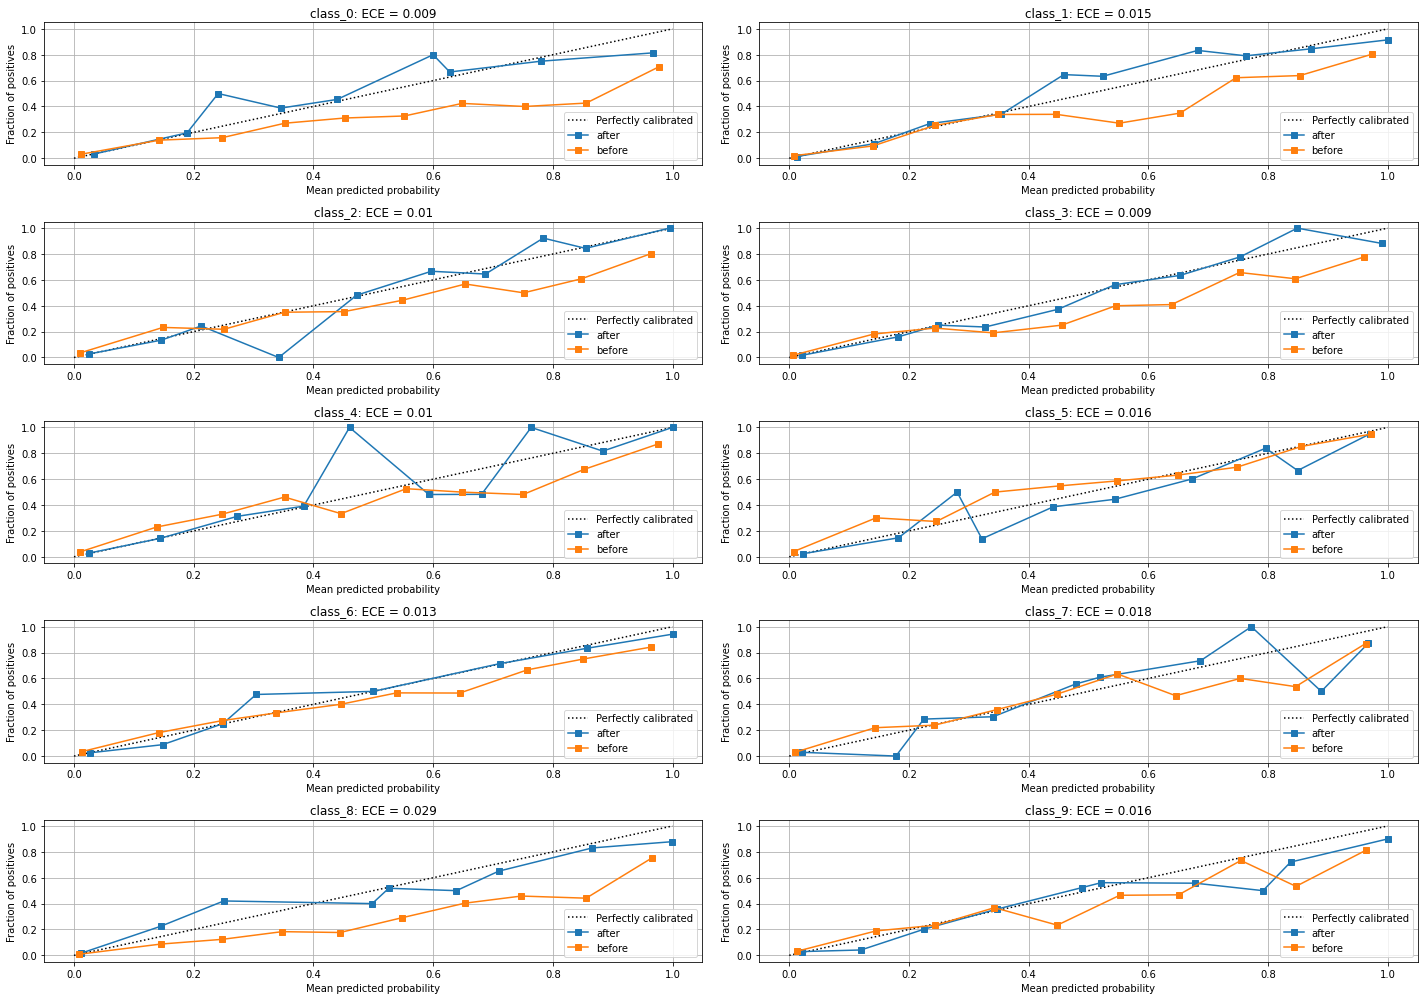

In [22]:
isotonic_metrics = show_calibration(isotonic_test_probs, test_targets, n_bins=N_BINS)

show_calibration_per_class(isotonic_test_probs, test_targets, n_bins=N_BINS, label='after',
                           transformed_probs=test_probs, transformed_label='before')

### Platt calibration

Изначально метод разрабатывался для SVM для бинарной классификации, оценки которого лежат на вещественной оси (по сути, это расстояния до оптимальной разделяющей классы прямой, взятые с нужным знаком). Предлагается 

$P(y=1|x) = \dfrac{1}{1 + exp(\alpha*f(x) + \beta)}$

где $f(x)$ это логит/confidance/вероятность от базовой модели, а $\alpha$ и $\beta$ - это настраиваемые параметры. Их можно настраивать методом максимального правдоподобия(CrossEntropyLoss) на отдельной выборке чтобы избежать переобучения. Но в оригинальной статье([link](https://home.cs.colorado.edu/~mozer/Teaching/syllabi/6622/papers/Platt1999.pdf)) предполагается вместо этого обучать на train выборке, но переопределись target следующим образом:

$y_+ = \dfrac{N_+ + 1}{N_+ + 2}$ , $y_{-} = \dfrac{1}{N_{-}+1}$, где $N_{+}$ и $N_{-}$ это количество объектов положительного и отрицательного класса соответственно

 

### Logistic Calibration(Matrix and Vector Scaling)

По сути является обобщением калибровки Платта:

$P(y=1|x) = \dfrac{1}{1 + exp(W*f(x) + \beta)}$ , где $W$ это матрица весов $l \times l$ , a $\beta$ - вектор сдвига


**Замечание**: Platt calibration и Logistic Calibration из netcal не работуют(на состояние 29.03.2023), класс netcal.scaling.LogisticCalibration

In [23]:
logistic_regression = LogisticRegression()
logistic_regression.fit(valid_probs, valid_targets)
logistic_test_probs = logistic_regression.predict_proba(test_probs)

ECE:  0.032
MCE:  0.081
accuracy 0.594


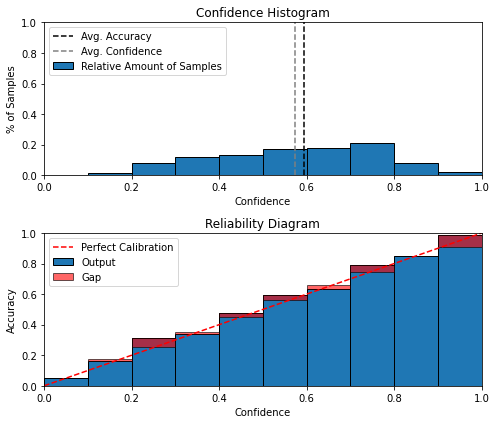

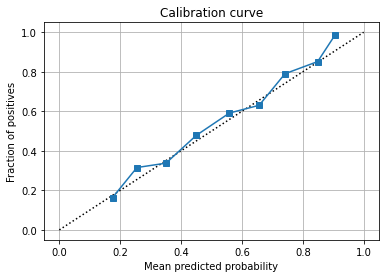

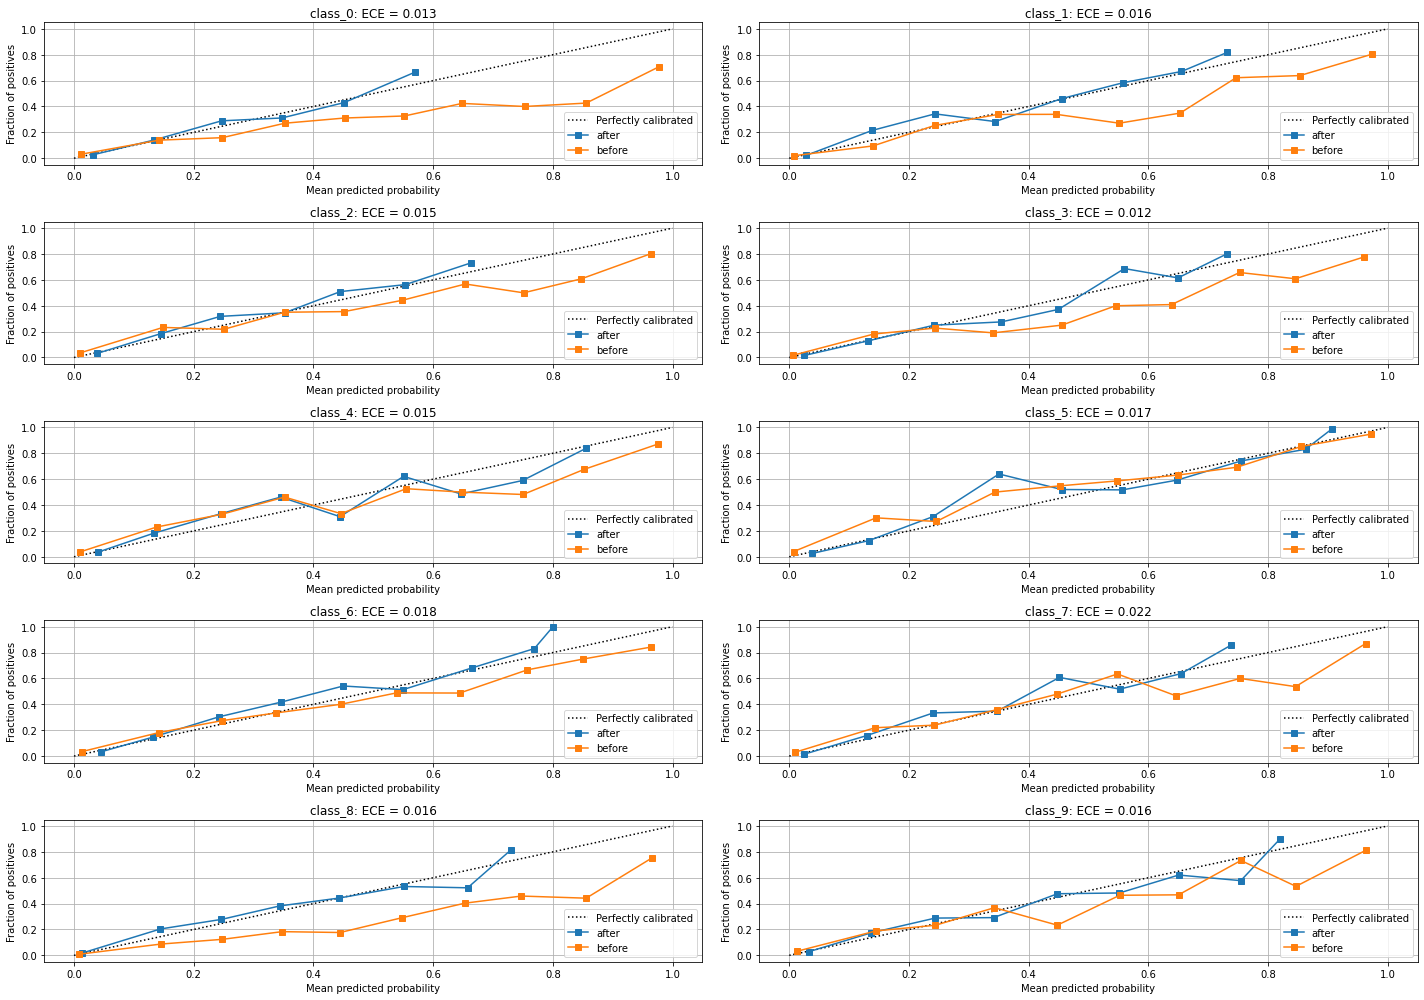

In [24]:
logistic_metrics = show_calibration(logistic_test_probs, test_targets, n_bins=N_BINS)

show_calibration_per_class(logistic_test_probs, test_targets, n_bins=N_BINS, label='after',
                           transformed_probs=test_probs, transformed_label='before')

### Temperature Scaling

Этот метод ([статья](https://arxiv.org/abs/1706.04599)) относится к классу DL-методов калибровки, не потому, что применяется исключительно в нейронных сетях, просто он был придуман и приобрёл популярность именно для калибровок нейронных сетей. Идея в том чтобы шкалировать вероятности используя только параметр температуры в SoftMax:

$a(x) = softmax(\frac{b_1}{T}, ...\frac{b_l}{T})$

Заметим, что от значения параметра $T$, который называется «температурой» не зависит результат классификации, поэтому не меняется точность калибруемого алгоритма. Как и раньше, параметр обучается на отложенном наборе данных,  минимизируя NLL. Основной недостаток метода – мы одновременно уменьшаем уверенность в неправильных предсказаниях и в правильных


Сравнение температурного шкалирования с другими методами
<img src="images/temperature_scaling.jpg"  width="600px" title="aaa">

__Замечание__: Температурное шкалирование из библиотеки `netcal` не работает(на сомтояние 29.03.2023)

In [25]:
import torch
import numpy as np
import scipy

from torch import nn, optim


class TemperatureScaler:
    """
    Основано на статье https://arxiv.org/abs/1706.04599
    """
    def __init__(self, lr: float = 0.005, max_iter: int = 1000):
        self._temperature = nn.Parameter(torch.ones(1))
        self.lr = lr
        self.max_iter = max_iter

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        
        :param X: np.ndarray: логиты модели, размерность [n_objects, n_classes]
        :param y: np.ndarray: истинные метки, размерность [n_objects,]
        """
        logits = torch.from_numpy(X)
        labels = torch.from_numpy(y)
        nll_criterion = nn.CrossEntropyLoss().cuda()

        optimizer = optim.LBFGS([self._temperature], lr=self.lr, max_iter=self.max_iter)

        def compute_loss():
            optimizer.zero_grad()
            loss = nll_criterion(logits / self._temperature, labels)
            loss.backward()
            return loss

        optimizer.step(compute_loss)

    def temperature(self) -> float:
        return float(self._temperature[0].detach().numpy())

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Преобразует логиты модели
        
        :param X: np.ndarray: логиты модели, размерность [n_objects, n_classes]
        :return: np.ndarray: откалиброванные вероятности модели, размерность [n_objects, n_classes]
        """
        return scipy.special.softmax(X / self.temperature(), axis=1)

ECE:  0.027
MCE:  0.045
accuracy 0.583


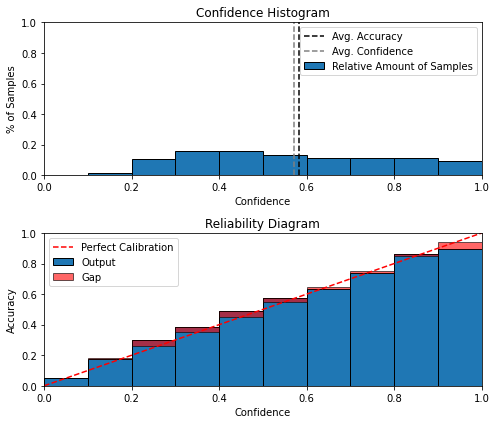

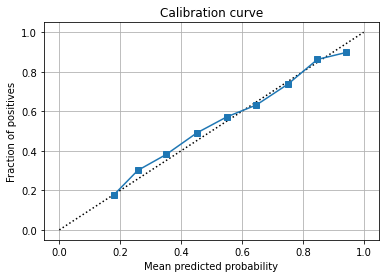

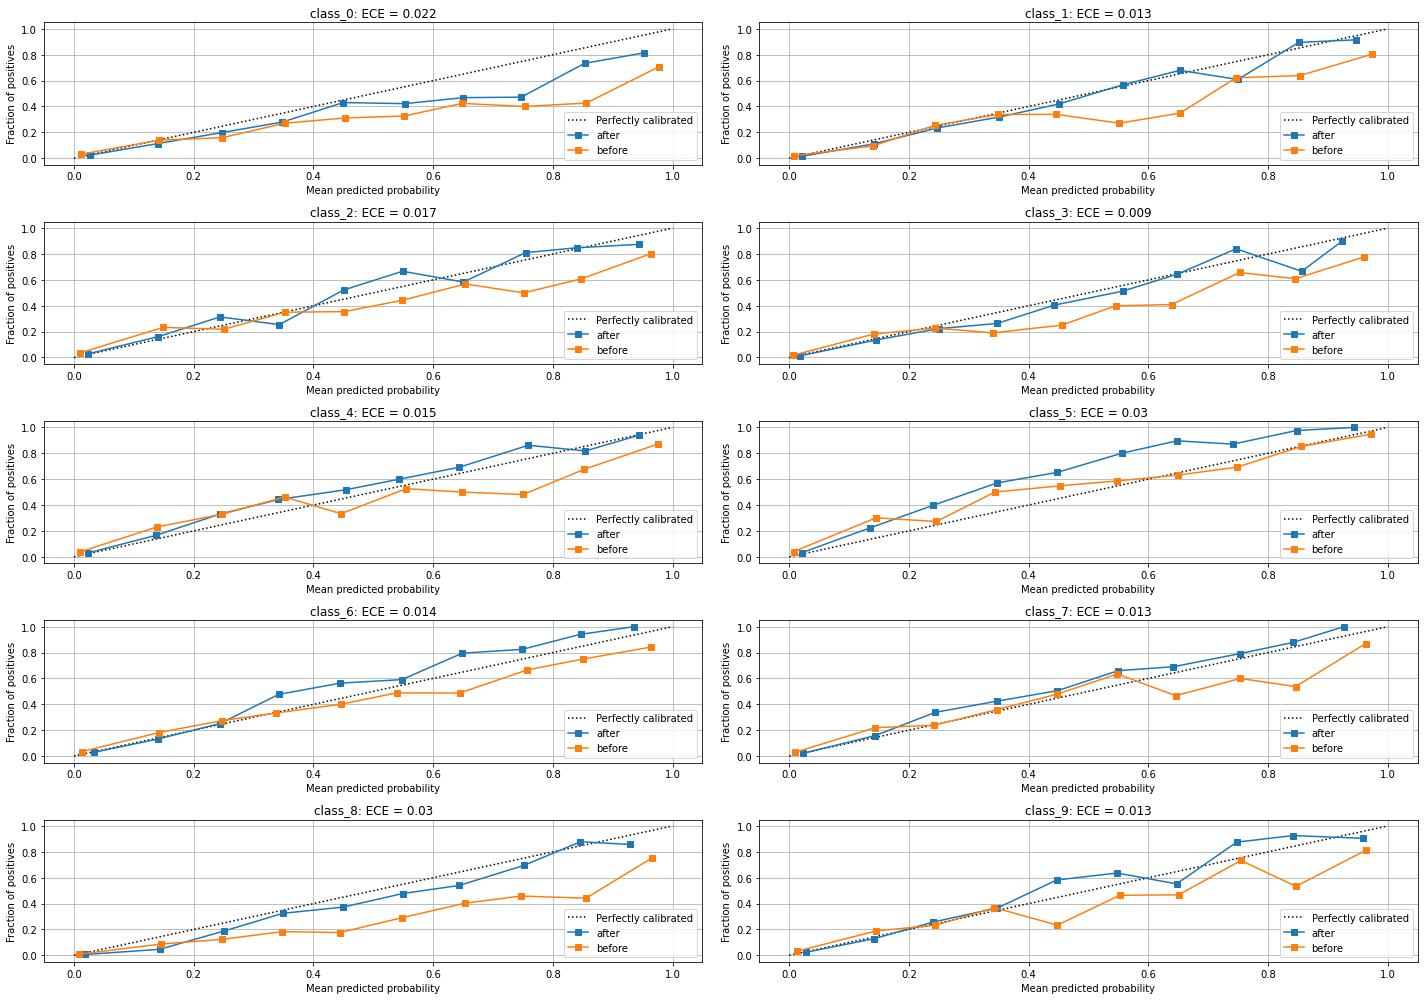

In [26]:
temperature_scaler = TemperatureScaler()
temperature_scaler.fit(valid_logits, valid_targets)
temperature_test_probs = temperature_scaler.transform(test_logits)

temperature_metrics = show_calibration(temperature_test_probs, test_targets, n_bins=N_BINS)

show_calibration_per_class(temperature_test_probs, test_targets, n_bins=N_BINS, label='after',
                           transformed_probs=test_probs, transformed_label='before')

## Калибровка при обучении

### Label Smoothing

Как и следует ожидать, в борьбе с пере-уверенностью должно помогать «сглаживание меток»([link](https://arxiv.org/pdf/1906.02629.pdf)). При обучении нейросети минимизируют кросс-энтропию между вектором оценок и «сглаженным вектором классификации»:

$y_k^{LS} = y_k(1-\alpha) + \frac{\alpha}{l}$ 

где  $\alpha$ это параметр сглаживания меток. Например, если у нас есть 4 класса и истинный класс 2 и параметр $\alpha = 0.1$, то target будет [0.025, 0.925, 0.025, 0.025].

Часто такую настройку совмещают с температурным шкалированием.

__Замечание__: в `torch`, можно использовать label smoothing просто добавляя параметр `label_smoothing` в критерий `nn.CrossEntropyLoss`

In [24]:
def create_smoothing_label(label: int, n_classes: int, alpha: float = 0.1) -> np.ndarray:
    """
    Создаем вектор сглаженных target для классификатора
    
    :param label: int: истинная метка
    :param n_classes: int: количества классов
    :param alpha: float: параметр сглаживания
    :return: np.ndarray: сглаженный вектор target, размерность [n_classes]
    """
    smoothing_label = np.ones((n_classes, )) * alpha / n_classes
    smoothing_label[label] += (1 - alpha)
    return smoothing_label

In [2]:
SMOOTHING = 0.01
# берем простую модель mobilenet_v2
model = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=10)

# в torch можно просто указать параметр label_smoothing в критерий
criterion = nn.CrossEntropyLoss(label_smoothing=SMOOTHING)

optimizer = optim.Adam(model.parameters(), lr=0.02)
runner = dl.SupervisedRunner(
    input_key="image", output_key="logits", target_key="targets", loss_key="loss"
)

# обучение модели
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders={'train': loaders['train'], 'valid':loaders['valid']},
    engine=DeviceEngine(DEVICE),
    num_epochs=30,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5)),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
    ],
    logdir="./logs_smoothing_4",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=False,
    load_best_on_end=True,
)

In [25]:
# берем простую модель mobilenet_v2
model = timm.create_model('mobilenetv2_100', pretrained=False, num_classes=10)

model.load_state_dict(torch.load('./logs_smoothing_4/checkpoints/best_full.pth')['model_state_dict'])

<All keys matched successfully>

In [26]:
smoothing_valid_probs, valid_targets = predict_loader(
    loader=loaders['valid'],
    model=model,
    activation=scipy.special.softmax
)

smoothing_test_probs, test_targets = predict_loader(
    loader=loaders['test'],
    model=model,
    activation=scipy.special.softmax
)

ECE:  0.136
MCE:  0.206
accuracy 0.554


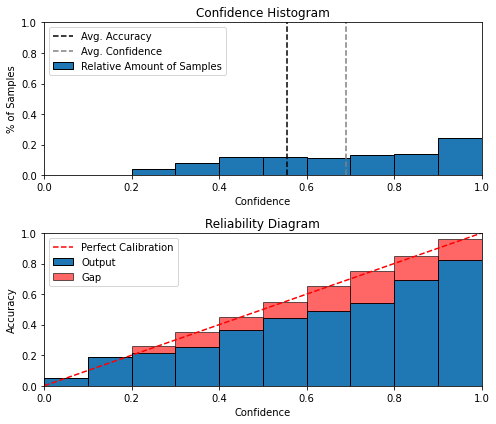

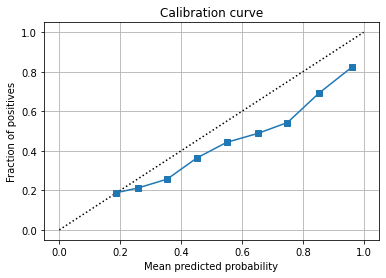

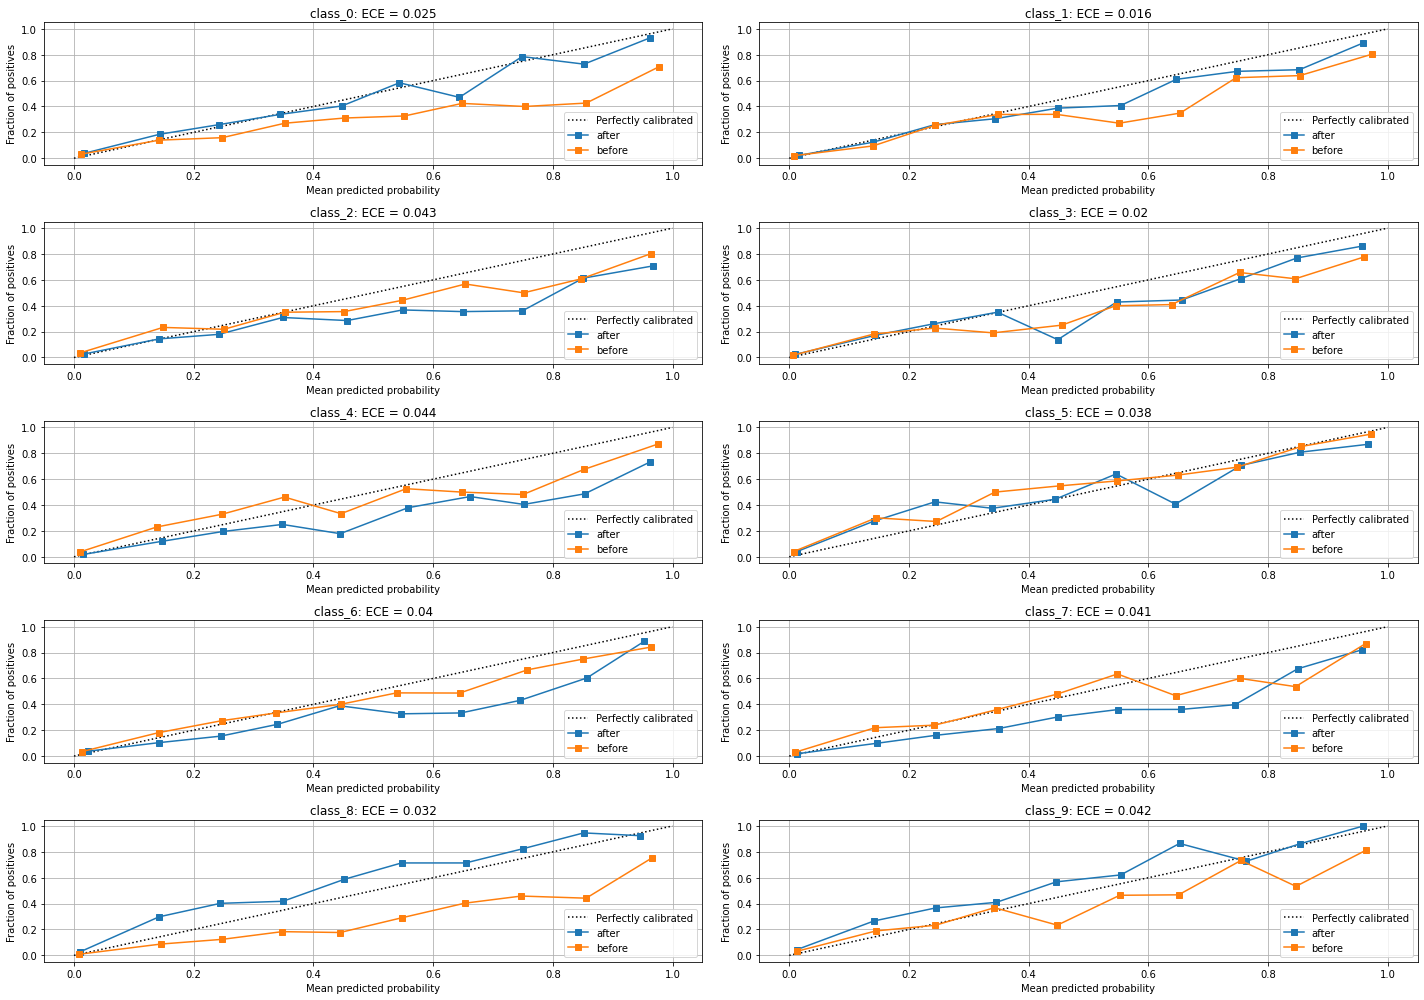

In [27]:
smoothing_metrics = show_calibration(smoothing_test_probs, test_targets, n_bins=N_BINS)

show_calibration_per_class(smoothing_test_probs, test_targets, n_bins=N_BINS, label='after',
                           transformed_probs=test_probs, transformed_label='before')

### Focal Loss


В статье [link](https://arxiv.org/pdf/2002.09437.pdf) показали что focal loss помогает обучать откалиброванные модели.

На изображении ниже показано как меняются показатели, связанные с калибровкой модели, при использованием Cross entropy и Focal Loss



<img src="images/focal_calibration.png"  width="1000px" title="aaa">

In [3]:
# берем простую модель mobilenet_v2
model = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=10)

# focal loss есть в catalyst
criterion = FocalLossMultiClass()

optimizer = optim.Adam(model.parameters(), lr=0.02)
runner = dl.SupervisedRunner(
    input_key="image", output_key="logits", target_key="targets", loss_key="loss"
)

# обучение модели
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders={'train': loaders['train'], 'valid':loaders['valid']},
    engine=DeviceEngine(DEVICE),
    num_epochs=30,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5)),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
    ],
    logdir="./logs_focal",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=False,
    load_best_on_end=True,
)

In [28]:
# загружаем модель
model = timm.create_model('mobilenetv2_100', pretrained=False, num_classes=10)
model.load_state_dict(torch.load('./logs_focal/checkpoints/best_full.pth')['model_state_dict'])

<All keys matched successfully>

In [29]:
focal_valid_probs, valid_targets = predict_loader(
    loader=loaders['valid'],
    model=model,
    activation=scipy.special.softmax
)

focal_test_probs, test_targets = predict_loader(
    loader=loaders['test'],
    model=model,
    activation=scipy.special.softmax
)

ECE:  0.089
MCE:  0.121
accuracy 0.42


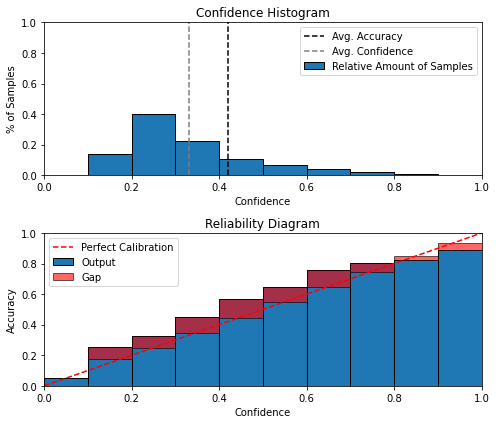

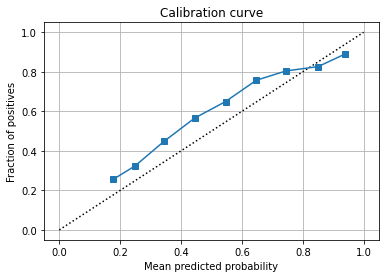

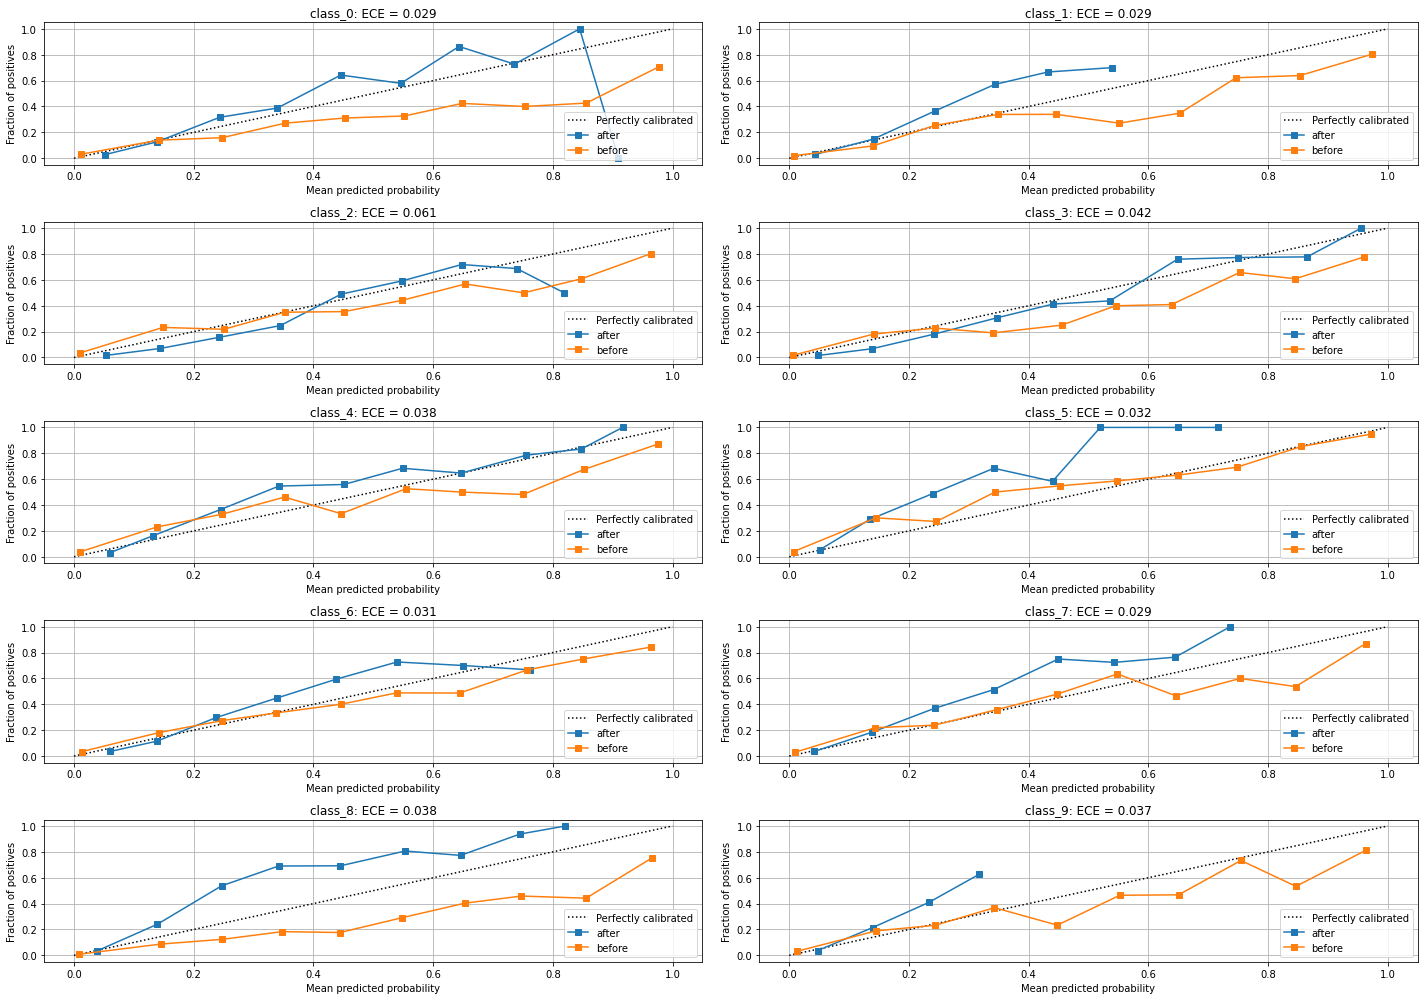

In [30]:
focal_metrics = show_calibration(focal_test_probs, test_targets, n_bins=N_BINS)

show_calibration_per_class(focal_test_probs, test_targets, n_bins=N_BINS, label='after',
                           transformed_probs=test_probs, transformed_label='before')

### DCA loss

В статье([link](https://arxiv.org/pdf/2009.04057.pdf)) предлагается использовать специальный лосс DCA, который работает как регуляризация и штрафует модель если средний confidence сильно отличается от среднего accuracy:

$DCA= |\frac{1}{N}\sum_{i=1}^Nc_i -\frac{1}{N}\sum_{i=1}^2p(\hat{y_i})|$

где $\hat{y_i}$ - это предсказанный класс(класс с самым большим confidence), $с_i =1$, если $\hat{y_i} = y_i$ и 0 иначе. В итоге предлагается добавлять эту регулеризацию к основному loss-у с некоторым коэффициентом  $\beta$

**Замечание**: авторы констатируют что очень важно найти оптимальный  $\beta$ довольно трудно, для большинства задач лучше использовать  $\beta \in (10, 15)$

In [42]:
import torch
from torch import nn
from torch.nn import functional as F

class DCALoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        predicted_probs = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(predicted_probs, 1)
        is_correct = predictions.eq(targets)
        mean_confidence = confidences.float().mean()
        accuracy = is_correct.float().sum() / len(is_correct)
        dca_loss = torch.abs(mean_confidence - accuracy)
        return dca_loss

In [4]:
# берем простую модель mobilenet_v2
model = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=10)

criterions = {'ce': nn.CrossEntropyLoss(),
             'dca': DCALoss()}

optimizer = optim.Adam(model.parameters(), lr=0.02)
runner = dl.SupervisedRunner(
    input_key="image", output_key="logits", target_key="targets", loss_key="loss"
)

# обучение модели
runner.train(
    model=model,
    criterion=criterions,
    optimizer=optimizer,
    loaders={'train': loaders['train'], 'valid':loaders['valid']},
    engine=DeviceEngine(DEVICE),
    num_epochs=30,
    callbacks=[
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="ce_loss", criterion_key='ce'),
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="dca_loss", criterion_key='dca'),
        dl.MetricAggregationCallback(metric_key='loss', mode='weighted_sum', metrics={"ce_loss": 1, "dca_loss": 1}),
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5)),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
    ],
    logdir="./logs_dca_1",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=False,
    load_best_on_end=True,
)

In [32]:
# загружаем модель
model = timm.create_model('mobilenetv2_100', pretrained=False, num_classes=10)
model.load_state_dict(torch.load('./logs_dca_1/checkpoints/best_full.pth')['model_state_dict'])


dca_valid_probs, valid_targets = predict_loader(
    loader=loaders['valid'],
    model=model,
    activation=scipy.special.softmax
)

dca_test_probs, test_targets = predict_loader(
    loader=loaders['test'],
    model=model,
    activation=scipy.special.softmax
)

ECE:  0.098
MCE:  0.19
accuracy 0.485


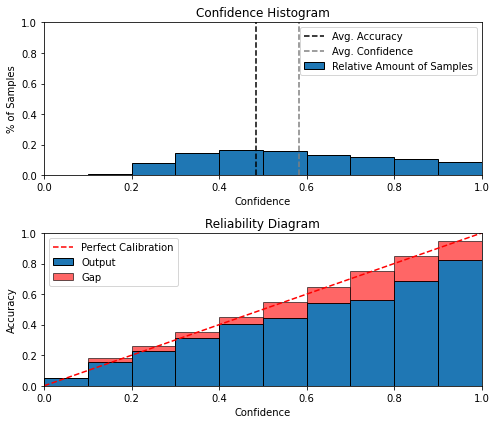

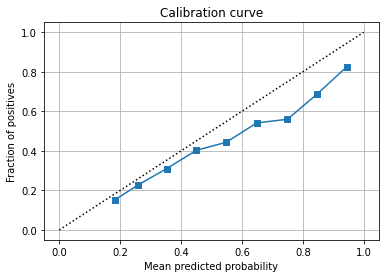

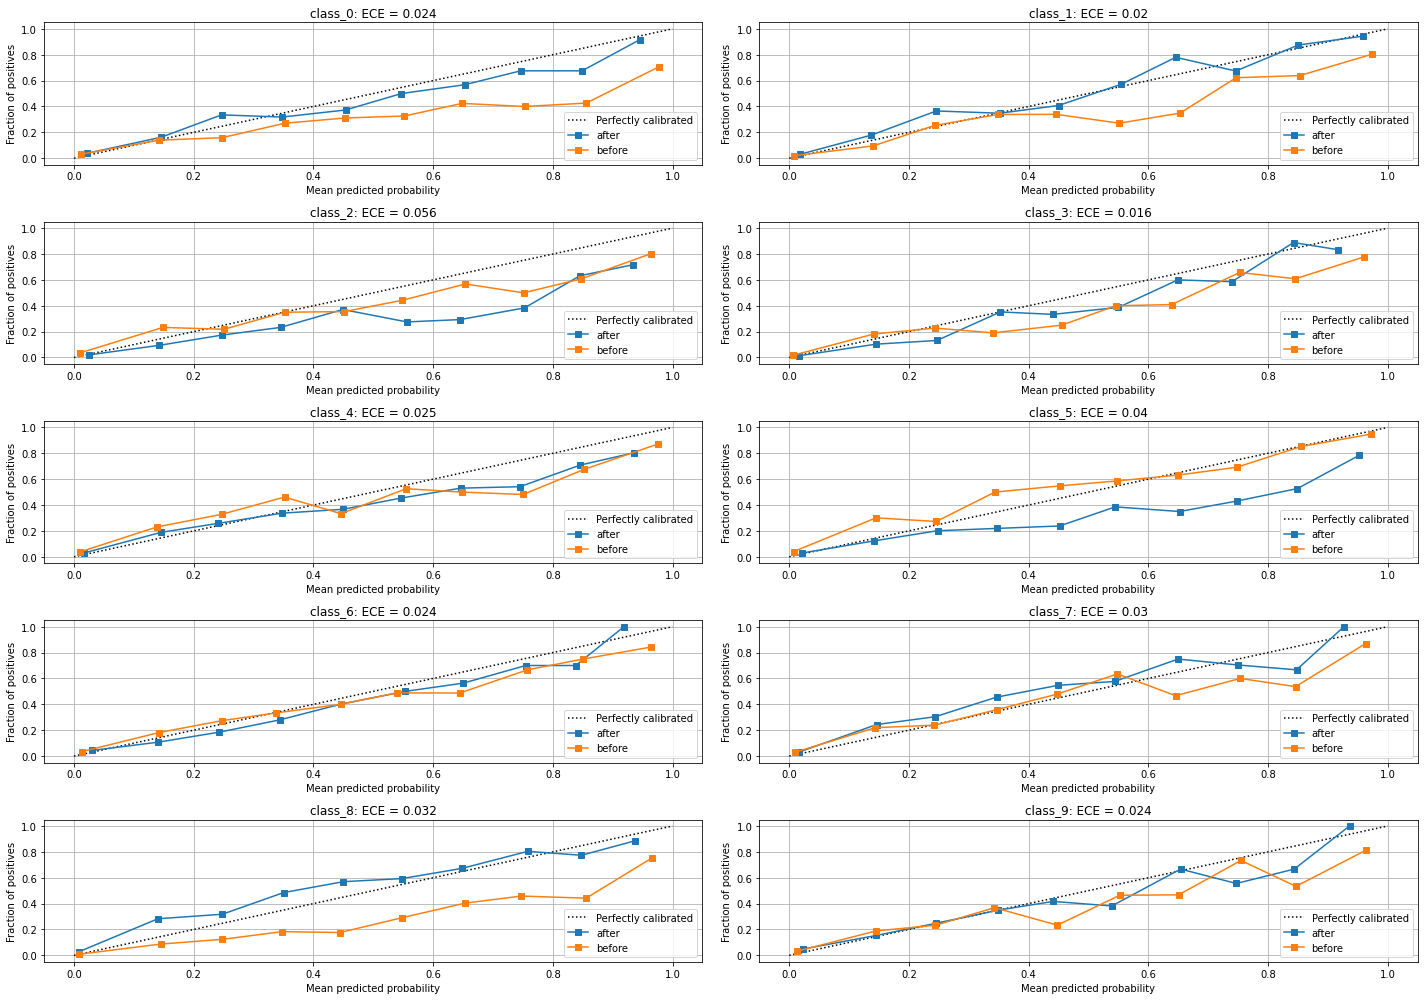

In [34]:
dca_metrics = show_calibration(dca_test_probs, test_targets, n_bins=N_BINS)

show_calibration_per_class(dca_test_probs, test_targets, n_bins=N_BINS, label='after',
                           transformed_probs=test_probs, transformed_label='before')

### Сравнение методов

Сравним все методы калибровки моделей

In [35]:
def compare_calibration(probs_list: List[np.ndarray],
                        targets: np.ndarray,
                        labels: List[str],
                        n_bins: int=10) -> None:
    fig = plt.figure(figsize=(10, 7))
    ax_calibration_curve = fig.add_subplot(1, 1, 1)
    for probs, label in zip(probs_list, labels):
        pred_probs = np.max(probs, axis=1)
        is_correct = np.argmax(probs, axis=1) == targets

        prob_true, prob_pred = calibration_curve(is_correct, pred_probs, n_bins=n_bins)
        disp = CalibrationDisplay(prob_true, prob_pred, pred_probs)
        disp.plot(name=label, ax=ax_calibration_curve)
        plt.grid()
    plt.title("Calibration curve")
    plt.show()

In [38]:
labels=['base', 'binning', 'binning_v2', 'isotonic', 'logistic', 'temperature', 'focal', 'smoothing', 'dca']

In [40]:
metrics_df = pd.DataFrame([metrics[:2], binning_metrics[:2], binning_metrics_v2[:2],
                           isotonic_metrics[:2], logistic_metrics[:2],
                           temperature_metrics[:2], focal_metrics[:2], smoothing_metrics[:2],
                           dca_metrics[:2]])
metrics_df = metrics_df.round(3)
metrics_df.index = labels
metrics_df.columns = ['ECE', 'MCE']
metrics_df.sort_values(by='ECE')

ECE    MCE
temperature  0.027  0.045
logistic     0.032  0.081
binning_v2   0.035  0.093
binning      0.036  0.078
isotonic     0.053  0.210
focal        0.089  0.121
dca          0.098  0.190
smoothing    0.136  0.206
base         0.167  0.305

Отрисуем все кривые калибровки на одном графике

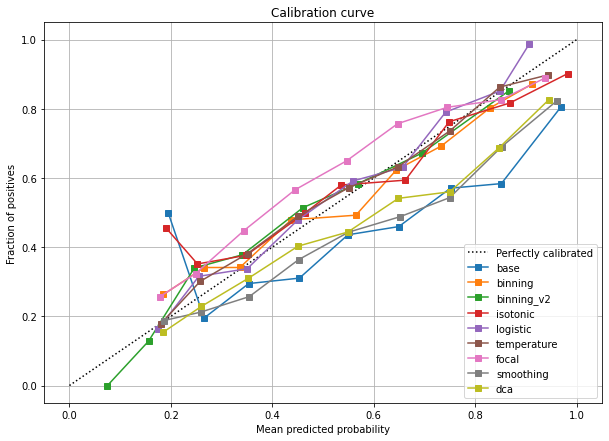

In [41]:
compare_calibration([test_probs, binning_test_probs, binning_test_probs_v2,
                     isotonic_test_probs, logistic_test_probs, temperature_test_probs,
                     focal_test_probs, smoothing_test_probs, dca_test_probs],
                    test_targets, labels=labels, n_bins=N_BINS)

Всегда нужно помнить что можно комбинировать методы калибровки. Например: можно обучать модель на smoothing label и поле использовать температурную калибровку

## Бонус

### Probability Calibration Trees

Все предыдущие алгоритмы для калибровки вероятности использовали только сами вероятности. Авторы этой статьи([link](http://proceedings.mlr.press/v77/leathart17a/leathart17a.pdf)) предложили алгоритм который для калибровки испольует также и сами данные. Идея в том чтобы делить объекты на похожие группы и каждую группу калибровать отдельно. 
<img src="images/probability_calibration_trees_scheme.png"  width="500px" title="aaa">
Предложенный алгоритм основан на использовании дерева для разбиения данных на группы.

1. Построить на исходных признаках решающее дерево, не очень глубокое чтобы в каждом листе было достаточно много объектов.
2. В каждом листе – обучить логистическую регрессию на одном признаке – предсказании класса основного алгоритма. 

При этом если основная модель выдает “вероятность”, а не отступ как в SVM, предсказания   перед подачей в логистическую регрессию трансформируется следующим образом $p = ln(\frac{p}{1-p})$

При этом дерево учиться на train выборке, а логистическая регрессия на valid выборке.

**Замечание**: Бабушкин В. утверждает что можно и то и другое учить на train и сильно хуже не будет

<img src="images/probability_calibration_trees.png"  width="500px" title="aaa">


Алгоритм инфереса:

- Получаем предсказание $S_1(x)$ с помощью основного алгоритма
- Используя признаки объекта $x$ определяем в какой лист дерева он попал
- Делаем предсказание с помощью логистической регрессии для этого листа(в качестве признака используется как раз $S_1(x)$)

**Замечание**: этот метод подходит только для табличных данных. Хотя конечно можно попробовать это использовать на эмбедингах выхода нейронной сети.

In [2]:
import pandas as pd
import lightgbm
import sklearn


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


MIN_SAMPLES_LEAF = 1700 # минимальное количество объектов в листе дерева калибровки
MAX_DEPTH = 5  # максимальная глубина дерева калибровки

Рассмотрим соревнование **Porto Seguro’s Safe Driver Prediction** [(link)](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/overview) и на его примере применим этот вариант калибровки. Данные можно сказать по [link](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data)

In [5]:
dataset = pd.read_csv('train.csv')
targets = dataset.target.values
dataset.drop(['id', 'target'], inplace=True, axis=1)
data = dataset.values

# разбиваем данные на train/valid/test
train_data, test_data, train_targets, test_targets = train_test_split(data, targets,
                                                                      test_size=0.6,
                                                                      random_state=13,
                                                                      stratify=targets)
valid_data, test_data, valid_targets, test_targets = train_test_split(test_data, test_targets,
                                                                      test_size=0.5,
                                                                      random_state=42,
                                                                      stratify=test_targets)

# создаем датасеты для бустинга
categorical_features = [c for c, col in enumerate(dataset.columns) if 'cat' in col]
train_dataset = lightgbm.Dataset(train_data, label=train_targets, categorical_feature=categorical_features)
test_dataset = lightgbm.Dataset(test_data, label=test_targets)
valid_dataset = lightgbm.Dataset(valid_data, label=valid_targets)

# обучаем градиентный бустинг
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}
model_xgb = lightgbm.train(parameters,
                           train_dataset,
                           valid_sets=valid_dataset,
                           num_boost_round=5000,
                           early_stopping_rounds=100,
                           verbose_eval = 100)

In [4]:
def show_binary_calibration(probs: np.ndarray,
                            targets: np.ndarray,
                            n_bins: int = 100) -> Tuple[float, float, float]:
    ece = ECE(n_bins, equal_intervals=False).measure(probs, targets)
    mce = MCE(n_bins, equal_intervals=False).measure(probs, targets)
    auc = sklearn.metrics.roc_auc_score(targets, probs)
    print("ECE: ", np.round(ece, 3))
    print("MCE: ", np.round(mce, 3))
    print("AUC", np.round(auc, 3))

    bin_edges = np.linspace(0, 1, n_bins + 1)  # определяем границы бинов
    bin_indices = np.digitize(probs, bin_edges)  # для каждого объекта определяем к каком бину он принадлежит

    # делаем равномощные бины
    sorted_idxes = np.argsort(probs)
    bins_confidence = [[] for _ in range(n_bins)]
    bins_accuracy = [[] for _ in range(n_bins)]
    bin_idx = 0
    length_array = len(sorted_idxes)
    step = 1. * length_array // n_bins
    for _ in range(n_bins):
        current_idx = int(step*bin_idx)
        next_idx = int(step*(bin_idx+1))
        bins_confidence[bin_idx] = np.mean(probs[sorted_idxes[current_idx:next_idx]])
        bins_accuracy[bin_idx] = np.mean(targets[sorted_idxes[current_idx:next_idx]])
        bin_idx += 1
        
    plt.scatter(bins_confidence, bins_accuracy)
    plt.xlabel('confidence')
    plt.ylabel('acuracy')
    plt.grid()
    plt.show()
    return ece, mce, auc

ECE:  0.409
MCE:  0.62
AUC 0.621


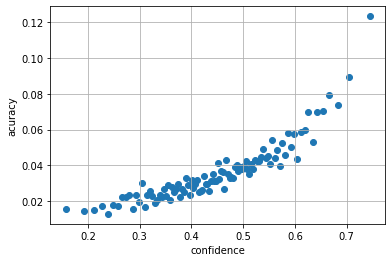

In [5]:
test_probs = model_xgb.predict(test_data)
metrics = show_binary_calibration(test_probs, test_targets)

Модель отвратительно откалибрована! Исправим их с помощью Probability Calibration Trees

In [6]:
def transform(x):
    return np.log(x/(1-x))

In [9]:
valid_probs = model_xgb.predict(valid_data)

# обучаем решающее дерево на данных из train
tree_model = DecisionTreeClassifier(min_samples_leaf=MIN_SAMPLES_LEAF, max_depth=MAX_DEPTH)
tree_model.fit(train_data, train_targets)

# делаем предсказание для валидационных данных
valid_probs_from_xgboost = model_xgb.predict(valid_data)
valid_probs_from_xgboost = valid_probs_from_xgboost.reshape((-1,1))

# определяем лист в которые попали валидационные данные
TREE = tree_model.tree_
indexes: List[int] = TREE.apply(valid_data.astype(np.float32))  # возвращает индекс листа в которое попал объект

# для каждого листа создаем и обучаем логистическую регрессию
log_reg_dict: Dict[int, LogisticRegression] = {}
nodes = np.unique(indexes)
for node in nodes:
    model = LogisticRegression()
    # определяем какие объекты попали в текущий лист
    node_probs = valid_probs_from_xgboost[indexes==node]
    node_targets = valid_targets[indexes==node]
    
    model.fit(transform(node_probs), node_targets)
    log_reg_dict[node] = model


Сделаем скалиброванные предсказания

In [10]:
# определяем лист дерева
indexes_test = TREE.apply(test_data.astype(np.float32))

# делаем предсказания основного алгоритма
test_probs_from_xgboost = model_xgb.predict(test_data)
test_probs_from_xgboost = test_probs_from_xgboost.reshape((-1,1))


calibrated_test_probs = np.zeros(len(test_probs_from_xgboost))
for node in log_reg_dict.keys():
    node_probs = test_probs_from_xgboost[indexes_test==node]
    # не забываем преобразовывать вероятности основного алгоритма
    node_probs = transform(node_probs)
    node_model = log_reg_dict[node]
    calibrated_test_probs[indexes_test==node] = node_model.predict_proba(node_probs)[:,1]#.reshape((-1,1))

ECE:  0.003
MCE:  0.013
AUC 0.625


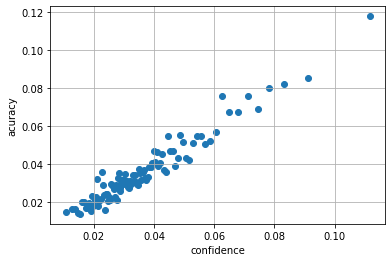

In [11]:
calibrated_metrics = show_binary_calibration(calibrated_test_probs, test_targets)

Как видим стало на порядок лучше. При этом нужно учитывать что целевая метрика AUC может незначительно измениться после калибровки